# Hidden Markov Models

In [1]:
import enum
import random

import numpy as np

from src.hmms.filtering import forward, forward_log, forward_naive
from src.hmms.smoothing import backward
from src.hmms.decoding import posterior, viterbi
from src.hmms.training import baum_welch

random.seed(42)
np.random.seed(42)

np.set_printoptions(precision=4, suppress=True)

Viterbi is optimal when one path dominates; posterior decoding is better when multiple paths are comparably probable.

### Numerical stability

Many expressions contain products of (a large number of) probabilities. This causes underflow when computing these expressions.

- For Viterbi algorithm, this can be solved by working with logarithms.
- For the forward and backward algorithms, an approximation with logarithms or rescaled variables can be used.

## Markov Chains

Sequence $\bm{x} = \alpha, x_1, x_2, \dots, x_L, \omega, \, x_i \in \mathcal{A} = \{A, C, T, G\}$.

Markov chain with transition probabilities $a_{st} = P(x_i = t \mid x_{i-1} = s)$:

$$
\begin{align*}
  P(\bm{x}) & = P(x_1, x_2, \dots, x_L) \\
  & = P(x_L \mid x_{L-1}, \dots, x_1) P(x_{L-1} \mid x_{L-2}, \dots, x_1) \dots P(x_1) \\
  & = P(x_L \mid x_{L-1}) P(x_{L-1} \mid x_{L-2}) \dots P(x_1) \text{, by the Markov property} \\
  & = P(x_1) \prod_{i=2}^L{P(x_i \mid x_{i-1})} = P(x_1) \prod_{i=2}^L{a_{x_{i-1} x_i}}
\end{align*}
$$

$$a_{\alpha s} = P(x_1 = s), a_{t \omega} = P(\omega \mid x_L = t)$$

The probability to observe a sequence of a given length decreases with the length of the sequence.

In [2]:
class State(enum.Enum):
    START = 0
    """\\alpha"""
    FAIR_DIE = 1
    BIASED_DIE = 2
    END = 3
    """\omega"""

EXPECTED_SEQUENCE_LENGTH = 300
r = (EXPECTED_SEQUENCE_LENGTH - 1) / EXPECTED_SEQUENCE_LENGTH
one_minus_r = 1 / EXPECTED_SEQUENCE_LENGTH

A = np.array([[0.0, 0.5, 0.5, 0.0],
     [0.0, r * 0.95, r * 0.05, one_minus_r],
     [0.0, r * 0.10, r * 0.90, one_minus_r],
     [0.0, 0.0, 0.0, 1.0]], dtype=np.float32)
"""Transition probabilities.
States (rows and cols; in this order): start \\alpha, fair, biased, end \omega."""

START, ONE, TWO, THREE, FOUR, FIVE, SIX, END = range(8)
"""Emissions"""

E = np.array([[1.0] + [0.0] * 7,
     [0.0] + [1/6] * 6 + [0.0],
     [0.0] + [1/10] * 5 + [1/2] + [0.0],  # Biased die: 6 is more likely
     [0.0] * 7 + [1.0]], dtype=np.float32)
"""Emission probabilities.
States (rows; in this order): start \\alpha, fair, biased, end \omega.
Emissions (cols; in this order): start \\alpha, 1, 2, 3, 4, 5, 6, end \omega"""

assert A.sum(axis=1).all() == 1.0, "Law of total probability"
assert E.sum(axis=1).all() == 1.0, "Law of total probability"

In [3]:
print(f"Probability of sequence of states {State.START} - {State.FAIR_DIE} - {State.BIASED_DIE} - {State.BIASED_DIE} - {State.END}:")
print(
    f"""A[{State.START.value + 1}, {State.FAIR_DIE.value + 1}] * A[{State.FAIR_DIE.value + 1}, {State.BIASED_DIE.value + 1}] * A[{State.BIASED_DIE.value + 1}, {State.BIASED_DIE.value + 1}] * A[{State.BIASED_DIE.value + 1}, {State.END.value + 1}] = {
    A[State.START.value, State.FAIR_DIE.value]
    * A[State.FAIR_DIE.value, State.BIASED_DIE.value]
    * A[State.BIASED_DIE.value, State.BIASED_DIE.value]
    * A[State.BIASED_DIE.value, State.END.value]* 10**5
    :.4f} * 10**(-5)"""
)

Probability of sequence of states State.START - State.FAIR_DIE - State.BIASED_DIE - State.BIASED_DIE - State.END:
A[1, 2] * A[2, 3] * A[3, 3] * A[3, 4] = 7.4501 * 10**(-5)


In [4]:
print(f"Probability of sequence of emissions {START} - {THREE} - {SIX} - {SIX} - {END} (given previous sequence of states):")
print(
    f"""E[{State.START.value + 1}, {START + 1}] * E[{State.FAIR_DIE.value + 1}, {THREE + 1}] * E[{State.BIASED_DIE.value + 1}, {SIX + 1}] * E[{State.BIASED_DIE.value + 1}, {SIX + 1}] * E[{State.END.value + 1}, {END + 1}] = {
    E[State.START.value, START]
    * E[State.FAIR_DIE.value, THREE]
    * E[State.BIASED_DIE.value, SIX]
    * E[State.BIASED_DIE.value, SIX]
    * E[State.END.value, END]
    :.4f}"""
)

Probability of sequence of emissions 0 - 3 - 6 - 6 - 7 (given previous sequence of states):
E[1, 1] * E[2, 4] * E[3, 7] * E[3, 7] * E[4, 8] = 0.0417


In [5]:
def casino2model(N: int) -> tuple[list[list[int]], list[list[State]]]:
    """Generate N sequences from a hidden Markov model of a casino.

    Args:
        N: Number of sequences to generate

    Returns:
        emissions: List of emission sequences
        states: List of state sequences
    """

    state_space = range(len(State))
    emission_space = range(len(E[0]))

    N_emissions, N_states = [], []
    for _ in range(N):
        emissions, states = [], []

        states.append((state := State.START.value))
        while state != State.END.value:
            emissions.append(random.choices(emission_space, weights=E[state], k=1)[0])
            states.append((state := random.choices(state_space, weights=A[state], k=1)[0]))
        emissions.append(END)

        assert len(emissions) == len(states)
        N_emissions.append(emissions)
        N_states.append(states)

    return N_emissions, N_states


emissions, states = casino2model(3)
print(len(emissions), len(states))
print()
for state_sequence, emission_sequence in zip(states, emissions):
    print(state_sequence)
    print(emission_sequence)
    print()

3 3

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## Reconstrucing the Hidden State Path: The Viterbi Algorithm

In HMMs, a sequence $\bm{x}$ is observed, and the objective is to reconstruct the hidden state sequence path by decoding of the best state path.

- Transition probabilities $a_{kl} = P(\pi_i = l \mid \pi_{i-1} = k, \bm{\theta})$
- Emission probabilities $e_k(b) = P(x_i = b \mid \pi_i = k, \bm{\theta})$
- Joint probability of sequence and path $P(\bm{x}, \bm{\pi} \mid \bm{\theta}) = P(x_1, \dots, x_L, \pi_1, \dots, \pi_L \mid \bm{\theta}) = \prod_{i=0}^L{ P(x_i \mid \pi_i, \bm{\theta}) P(\pi_{i+1} \mid \pi_i, \bm{\theta}) } = \prod_{i=0}^L{e_{\pi_i}(x_i) a_{\pi_i \pi_{i+1}}}$ (with implicit conditioning on $\bm{\theta}$)

The most probable path $\bm{\pi}^* = \argmax_\pi{P(\bm{x}, \pi)} = \argmax_\pi{P(\bm{\pi} \mid \bm{x})}$ can be found with dynamic programming.

Define $v_k(i) = \max_{\pi_1, \dots \pi_{i-1}}{P(x_1, \dots, x_i, \pi_1, \dots, \pi_{i-1}, \pi_i = k)}$ as the probability of the most probable path that ends in state $k$ for the emission of symbol $x_i$. Then this probability can be computed recursively as $v_l(i+1) = e_l(x_{i+1}) \max_k\big(v_k(i) \, a_{kl} \big)$.

0. Initial condition:
   $$v_\alpha(0) = 1, \quad v_k(0) = 0, \forall k \neq \alpha$$
1. Recursion ($i = 1, \dots, L-1$):
   $$v_l(i+1) = e_l(x_{i+1}) \max_k{ \big(v_k(i) \, a_{kl} \big) }$$
   $$\text{ptr}_l(i) = \argmax_k{ \big(v_k(i) \, a_{kl} \big) }$$
2. Termination:
   $$P(\bm{x}, \bm{\pi}^*) = v_\omega(L) \quad \Big( = \max_k{\big(v_k(L) \, a_{k0} \big)} \Big)$$
   $$\pi_L^* = \omega \quad \Big( = \argmax_k{\big(v_k(L) \, a_{k0} \big)} \Big)$$
3. Traceback ($i = L-1, \dots, 1$):
   $$\pi_i^* = \text{ptr}_{\pi_{i+1}^*}{(i)}$$

### Implementation (for numerical stability):

$$V_k(i) = \log{V_k(i)} = \max_{\pi_1, \dots \pi_{i-1}}{ \log{ P(x_1, \dots, x_i, \pi_1, \dots, \pi_{i-1}, \pi_i = k) } }$$

0. Initial condition:
   $$V_\alpha(0) = 0 (= \log{1}), \quad V_k(0) = - \infty, \forall k \neq \alpha$$
1. Recursion ($i = 1, \dots, L-1$):
   $$V_l(i+1) = \log{ e_l(x_{i+1}) } + \max_k{ \big(V_k(i) + \log{ a_{kl} } \big) }$$
   $$\text{ptr}_l(i) = \argmax_k{ \big(V_k(i) + \log{ a_{kl} } \big) }$$
2. Termination:
   $$P(\bm{x}, \bm{\pi}^*) = V_\omega(L) \quad \Big( = \max_k{\big(V_k(L) + \log{ a_{k0} } \big)} \Big)$$
   $$\pi_L^* = \omega \quad \Big( = \argmax_k{\big(V_k(L) + \log{ a_{k0} } \big)} \Big)$$
3. Traceback ($i = L-1, \dots, 1$):
   $$\pi_i^* = \text{ptr}_{\pi_{i+1}^*}{(i)}$$

In [6]:
emissions, states = casino2model(1)
x, hidden_path = emissions[0], states[0]
viterbi_path = viterbi(x, A, E)
print(hidden_path)
print(viterbi_path)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 

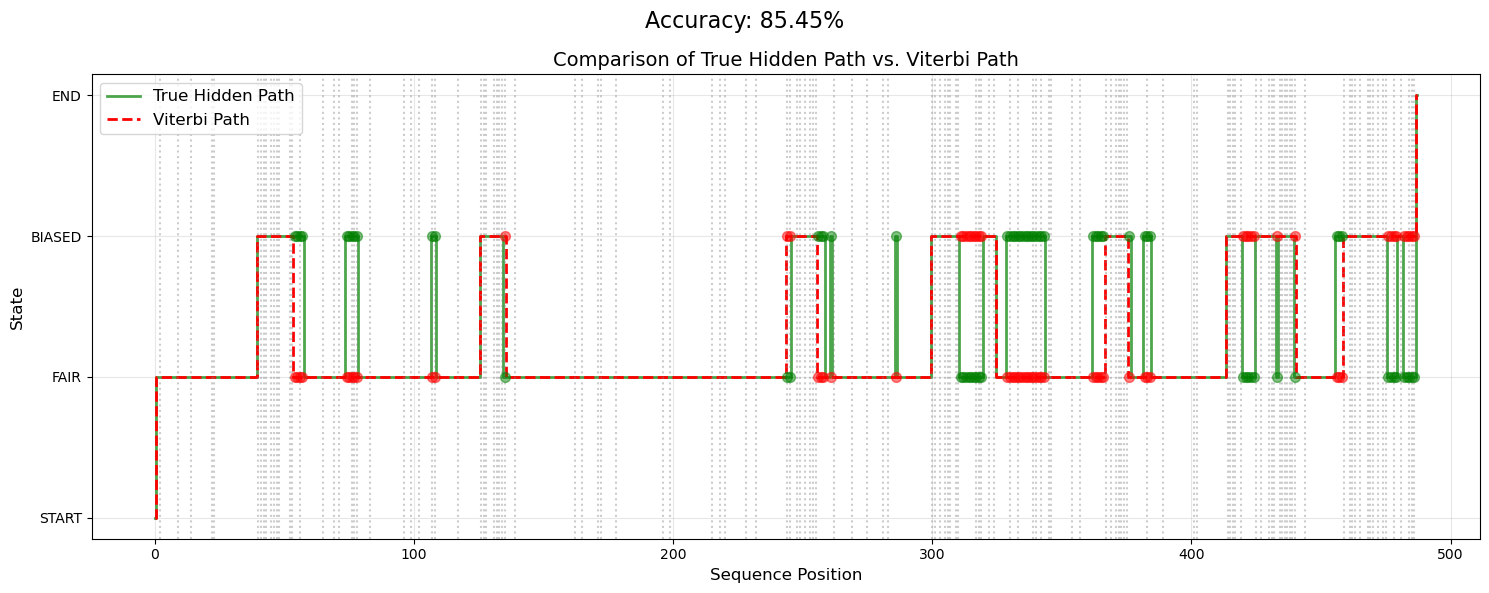

In [7]:
from src.hmms.plots import plot_paths

# Add markers for die rolls of '6' which are significant indicators of the biased die
plot_paths(x, hidden_path, viterbi_path, biased_observations=[SIX], reconstruction_algorithm="Viterbi")

The Viterbi path seems to change states far fewer times than the real path does.

## Computing The Probability of a Sequence: The Forward Algorithm

The forward algorithm computes the probability of a sequence $\bm{x}$ w.r.t. a HMM:

$$P(\bm{x}) = \sum_\pi{P(x, \pi)}$$

Define $f_k(i) = P(x_1, \dots, x_i, \pi_i = k)$ as the probability of the sequence for the paths that end in state $k$ with the emission of symbol $x_i$. Then it can be computed as

$$f_l(i+1) = e_l(x_{i+1}) \sum_k{f_k(i) a_{kl}}$$

The forward algorithm grows the total probability dynamically from the beginning to the end of the sequence.

0. Initial condition: sequence in beginning state ($i=0$):
   $$f_\alpha(0) = 1, f_k(0) = 0, \forall k > 0$$
1. Recursion ($i = 1, \dots, L$):
   $$f_l(i) = e_l(x_i) \sum_k{f_k(i-1) a_{kl}}$$
2. Termination: all states converge to the end state
   $$P(\bm{x}) = f_\omega(L) \quad (= \sum_k{f_k(L) a_{k0}})$$

In [8]:
log_prob, F = forward_naive(x, A, E)
print(log_prob)
print(F)

0.0
[[1.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.0833 0.014  ... 0.     0.     0.    ]
 [0.     0.05   0.0245 ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]


Using the logarithm like with the Viterbi algorithm to avoid underflow doesn't work why?

In [9]:
log_prob, F = forward_log(x, A, E)
print(log_prob)
print(F)

nan
[[  0.  nan  nan ...  nan  nan  nan]
 [-inf  nan  nan ...  nan  nan  nan]
 [-inf  nan  nan ...  nan  nan  nan]
 [-inf  nan  nan ...  nan  nan  nan]]


To deal with underflow, rescale the $f_k(i)$ s:

$$\tilde{f}_k(i) = \frac{f_k(i)}{\prod_{j=1}^i{s_j}} \text{ with } s_1, \dots, s_i \text{ s.t. } \sum_k{\tilde{f}_k(i)} = 1 \quad \forall i$$

The recursion relation becomes:

$$f_l(i) = e_l(x_i) \sum_k{f_k(i-1) a_{kl}}$$

$$\tilde{f}_l(i) \prod_{j=1}^i{s_j} = e_l(x_i) \sum_k{ \tilde{f}_k(i-1) \prod_{j=1}^{i-1}{s_j} a_{kl}}$$

$$\tilde{f}_l(i) = \frac{1}{s_i} e_l(x_i) \sum_k{ \tilde{f}_k(i-1) a_{kl}}$$

Since $\sum_l{\tilde{f}_l(i)} = 1$, by definition, it follows that

$$1 = \frac{1}{s_i} \sum_l{ e_l(x_i) \sum_k{ \tilde{f}_k(i-1) a_{kl}} }$$

$$s_i = \sum_l{ e_l(x_i) \sum_k{ \tilde{f}_k(i-1) a_{kl}} }$$

$$\tilde{f}_l(i)
= \frac{f_l(i)}{\prod_{j=1}^i{s_j}}
= \frac{ e_l(x_i) \sum_k{f_k(i-1) a_{kl}} }{ \prod_{j=1}^i{s_j} }
= \frac{ e_l(x_i) \sum_k{\tilde{f}_k(i-1) \prod_{j=1}^{i-1}{s_j} a_{kl}} }{ \prod_{j=1}^i{s_j} }
= \frac{ e_l(x_i) \sum_k{\tilde{f}_k(i-1) a_{kl}} }{s_i}$$

The rescaled procedure becomes:

0. Initial condition: sequence in beginning state ($i=0$):
   $$\tilde{f}_\alpha(0) = 1, \tilde{f}_k(0) = 0, \forall k > 0$$
1. Recursion ($i = 1, \dots, L$):
   $$\tilde{f}_l(i) = \frac{ e_l(x_i) \sum_k{\tilde{f}_k(i-1) a_{kl}} }{s_i} \quad \Bigg( = \frac{ e_l(x_i) \sum_k{\tilde{f}_k(i-1) a_{kl}} }{\sum_l{ e_l(x_i) \sum_k{ \tilde{f}_k(i-1) a_{kl}} }} \Bigg)$$
2. Termination: all states converge to the end state
   $$P(\bm{x}) = f_\omega(L) \quad (= \sum_k{f_k(L) a_{k0}})$$

In [10]:
log_prob, F, s = forward(x, A, E)
print(log_prob)

-851.009940719597


## Computing the Probability of a State: The Backward Algorithm

The backward algorithm computes the probability of the complete sequence together with the condition that symbol $x_i$ is emitted from state $k$. This is important to compute the probability of a given state at symbol $x_i$:

$$
\begin{align*}
  P(x, \pi_i = k) & = P(x_1, \dots, x_i, \pi_i = k) P(x_{i+1}, \dots, x_L \mid x_1, \dots, x_i, \pi_i = k) \\
   & = P(x_1, \dots, x_i, \pi_i = k) P(x_{i+1}, \dots, x_L \mid \pi_i = k)
\end{align*}
$$

- $P(x_1, \dots, x_i, \pi_i = k)$ can be computed with the forward algorithm.
- The backward algorithm grows the probability $b_k(i) = P(x_{i+1}, \dots, x_L \mid \pi_i = k)$ dynamically backwards (from end to beginning):
  - Initialisation ($i = L$): start in end state:
    $$b_\omega(L) = 1, b_k(L) = 0, \, \forall k \neq \omega \quad ( b_k(L) = a_{k0}, \, \forall k )$$
  - Recursion ($i = L-1, \dots, l$):
    $$b_k(i) = \sum_k{a_{kl} e_l(x_{i+1}) b_l(i+1)}$$
  - Termination:
    $$P(x) = b_1(1) \quad ( P(x) = \sum_l{a_{0l} e_l(x_1) b_l(1)} )$$

Using the scaling factors $s_j$ from the forward algorithm s.t. $\tilde{b}_k(i) = \frac{b_k(i)}{\prod_{j=i}^L{s_j}}$:

- Initialisation ($i = L$): start in end state:
  $$\tilde{b}_\omega(L) = \frac{1}{s_L}, \tilde{b}_k(L) = 0, \, \forall k \neq \omega$$
- Recursion ($i = L-1, \dots, l$):
  $$\tilde{b}_k(i) = \frac{1}{s_i} \sum_k{a_{kl} e_l(x_{i+1}) \tilde{b}_l(i+1)}$$
- Termination:
  $$b_\alpha(1) = 1 \quad ( = \frac{P(x)}{\prod_{j=i}^L{s_j}} = \frac{\prod_{j=i}^L{s_j}}{\prod_{j=i}^L{s_j}} )$$

In [11]:
B = backward(x, A, E, s)

## Reconstrucing the Hidden State Path: Posterior Decoding

The Viterbi algorithm computes the most likely sequence of states a given sequence is generated from. Posterior decoding instead looks at each index separately and determines the most likely state for that particular index.

The path of the most probable states can be used:

$$\hat{\pi}_i = \argmax_k{P(\pi_i = k \mid x)}$$

The posterior probability of the state can be computed using the forward and backward probabilities:

$$P(\pi_i = k \mid x) = \frac{f_k(i) b_k(i)}{P(x)}$$

In [12]:
posterior_path = posterior(x, F, B, s)
print(hidden_path)
print(posterior_path)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 

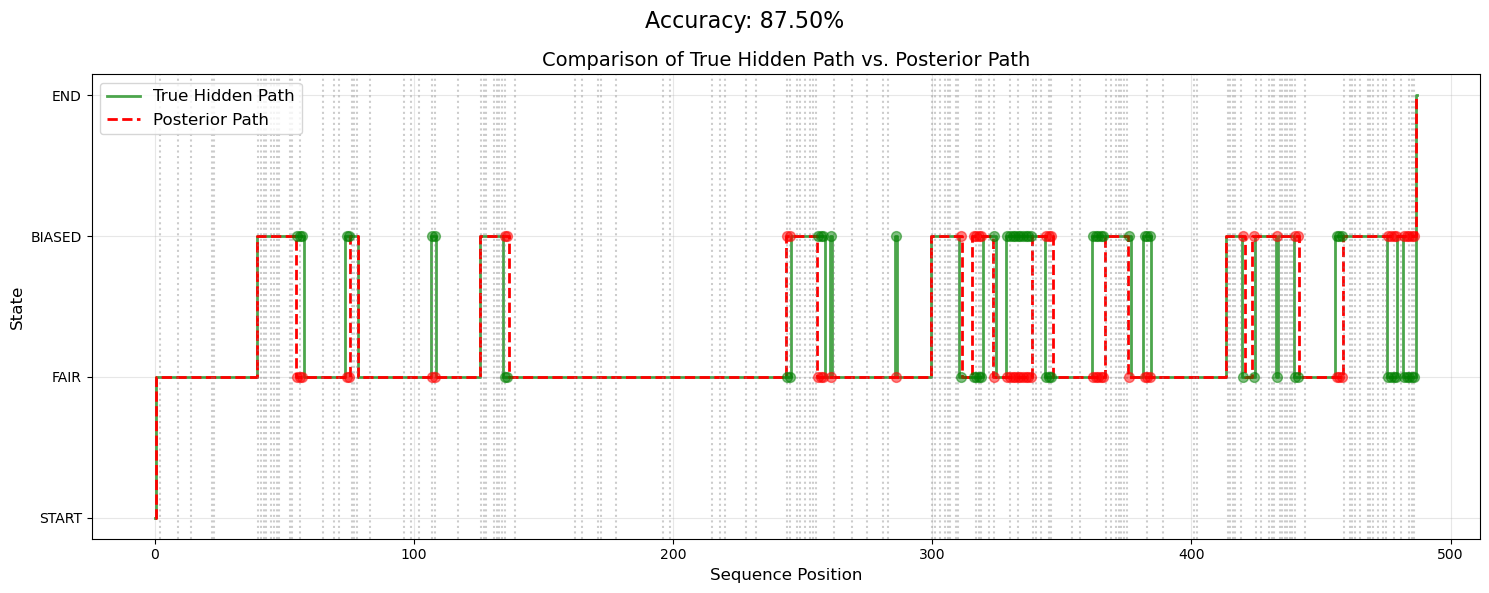

In [13]:
plot_paths(x, hidden_path, posterior_path, biased_observations=[SIX], reconstruction_algorithm="Posterior")

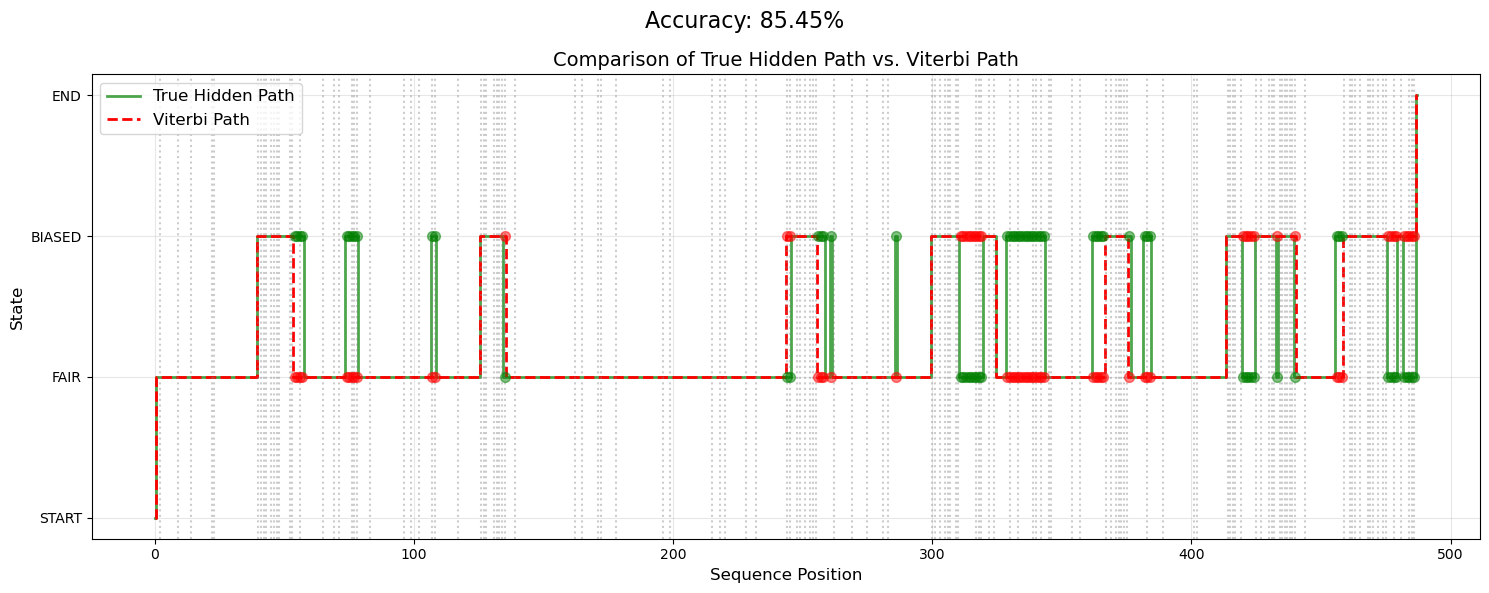

In [14]:
plot_paths(x, hidden_path, viterbi_path, biased_observations=[SIX], reconstruction_algorithm="Viterbi")

## Parameter Estimation

### Parameter estimation with known paths

Assumption: HMM architecture known. (Choice of architecture is an essential design choice.) Architecture may include "silent states" for gaps.

The score of the model is the likelihood of the parameters given the training data $D$ of $N$ sequences $x^1, \dots, x^N$:

$$\text{Score}(D, \theta) = \log{P(x^1, \dots, x^N \mid \theta) = \sum_{j=1}^N{\log{P(x^j \mid \theta)}}}$$

If the state paths are known, the parameters are estimated through counts (how often is a transition used, how often is a symbol produced by a given state):

$$a_{kl} = \frac{A_{kl}}{\sum_{l'}{A_{kl}}}, \, e_k(b) = \frac{E_k(b)}{\sum_{b'}{E_k(b')}}$$

using pseudocounts:

- $A_{kl}$ is the number of transitions from $k$ to $l$ in training set + pseudocount $r_{kl}$
- $E_k(b)$ is the number of emissions of $b$ from $k$ in training set + pseudocount $r_k(b)$

### Parameter estimation with known paths: Viterbi learning

Iterative method:

- Suppose that the parameters are known and find the best path.
- Use Viterbi decoding to estimate the parameters.
- Iterate till convergence. Viterbi training converges exactly in a finite number of steps.

Viterbi training does not maximise the likelihood of the parameters.

$$\theta^\text{Vit} = \argmax_\theta{P(x^1, \dots, x^N \mid \theta, \pi_\theta^*(x^1), \dots, \pi_\theta^*(x^N))}$$

### Parameter Estimation with Known Paths: The Baum-Welch Algorithm

Strategy: use the expected value for the transition and emission counts (instead of using only the best path)

- Initialization: Choose arbitrary model parameters
- Recursion:
  - Set all transitions and emission variables to their pseudocount
  - For all sequences $j = 1, \dots, n$
    - Compute $f_k(i)$ for sequence $j$ with the forward algorithm
    - Compute $b_k(i)$ for sequence $j$ with the backward algorithm
    - Add the contributions to $A$ and $E$
  - Compute the new model parameters $a_{kl}, e_k(b)$
    $$A_{kl} = \sum_{x \in X}{\frac{1}{P(x)}} \sum_{i=1}{L-1}{f_k(i) \, a_{kl} \, e_l(x_{i+1}) \, b_l(i+1)}$$
    $$E_{kb} = \sum_{x \in X}{\frac{1}{P(x)}} \sum_{i: x_i = b}{f_k(i) \, b_k(i)}$$
  - Compute the log-likelihood of the model
- End: stop when the log-likelihood does not change more than by some threshold or when the maximum number of iterations is exceeded

In [16]:
X, _ = casino2model(100)
K, U = A.shape[1], E.shape[1]

for eps in [0.1, 0.01, 0.001]:
    print(f"{eps = }:")
    A_est, E_est = baum_welch(X, K, U, eps=eps)
    print()
    print(A)
    print("Estimated transition matrix:")
    print(A_est)
    print()
    print(E)
    print("Estimated emission matrix:")
    print(E_est)
    print()
    print()

eps = 0.1:


  1%|▏         | 4/300 [00:00<01:02,  4.71it/s]



[[0.     0.5    0.5    0.    ]
 [0.     0.9468 0.0498 0.0033]
 [0.     0.0997 0.897  0.0033]
 [0.     0.     0.     1.    ]]
Estimated transition matrix:
[[0.     0.3505 0.6495 0.    ]
 [0.     0.0605 0.9363 0.0032]
 [0.     0.1133 0.8834 0.0033]
 [0.     0.     0.     1.    ]]

[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.1667 0.1667 0.1667 0.1667 0.1667 0.1667 0.    ]
 [0.     0.1    0.1    0.1    0.1    0.1    0.5    0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]
Estimated emission matrix:
[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.2475 0.0825 0.1446 0.0527 0.093  0.3796 0.    ]
 [0.     0.1353 0.1523 0.1422 0.1546 0.1512 0.2645 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]


eps = 0.01:


 88%|████████▊ | 264/300 [00:44<00:06,  5.93it/s]



[[0.     0.5    0.5    0.    ]
 [0.     0.9468 0.0498 0.0033]
 [0.     0.0997 0.897  0.0033]
 [0.     0.     0.     1.    ]]
Estimated transition matrix:
[[0.     0.5088 0.4912 0.    ]
 [0.     0.9428 0.0545 0.0027]
 [0.     0.0979 0.8978 0.0043]
 [0.     0.     0.     1.    ]]

[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.1667 0.1667 0.1667 0.1667 0.1667 0.1667 0.    ]
 [0.     0.1    0.1    0.1    0.1    0.1    0.5    0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]
Estimated emission matrix:
[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.1735 0.1655 0.1678 0.1646 0.1691 0.1595 0.    ]
 [0.     0.1008 0.1074 0.097  0.1057 0.1013 0.4879 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]


eps = 0.001:


 73%|███████▎  | 218/300 [00:37<00:13,  5.89it/s]


[[0.     0.5    0.5    0.    ]
 [0.     0.9468 0.0498 0.0033]
 [0.     0.0997 0.897  0.0033]
 [0.     0.     0.     1.    ]]
Estimated transition matrix:
[[0.     0.5119 0.4881 0.    ]
 [0.     0.9441 0.0531 0.0027]
 [0.     0.0967 0.8989 0.0043]
 [0.     0.     0.     1.    ]]

[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.1667 0.1667 0.1667 0.1667 0.1667 0.1667 0.    ]
 [0.     0.1    0.1    0.1    0.1    0.1    0.5    0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]
Estimated emission matrix:
[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.1732 0.1653 0.1675 0.1644 0.1689 0.1606 0.    ]
 [0.     0.1007 0.1072 0.0969 0.1056 0.1011 0.4885 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]




The epsilon parameter (`eps`) in Baum-Welch represents the convergence threshold for stopping the algorithm. Counterintuitively, a higher epsilon can sometimes yield better estimations for several reasons:

1. **Early Stopping as Regularization**
   - The Baum-Welch algorithm can overfit to your training data
   - Higher epsilon causes earlier termination, acting as a form of regularization
   - This prevents the model from learning noise in the data

2. **Avoiding Local Optima**
   - Baum-Welch often gets trapped in local optima
   - Early stopping can prevent the algorithm from converging to a suboptimal solution
   - The algorithm might be on a trajectory toward a better global optimum when a higher epsilon stops it

3. **Parameter Oscillation**
   - With very small epsilon values, parameters might oscillate in tiny increments without meaningful improvement
   - Higher epsilon stops when the fluctuations become small enough to be insignificant

4. **Numerical Precision Issues**
   - With very small epsilon values, numerical precision problems can arise
   - Differences smaller than machine precision become meaningless

A good strategy is to try different epsilon values and evaluate model performance on validation data.

## Profiles

Profiles are computational models used to represent the characteristic patterns of protein families, domains, or motifs.
They are built from multiple sequence alignments and capture the conservation and variability at each position in the alignment.

[Profile HMMs](https://nl.mathworks.com/help/bioinfo/ref/hmmprofstruct.html) require **silent states**. Silent states do not emit a symbol, e.g. delete states in a profile HMM (represented in orange in the figure below). The start and end states are also usually silent states.

<img src="https://nl.mathworks.com/help/bioinfo/ref/hmm_summaryfigure.gif">

Implementing silent states requires adapting of the forward, backward, and Baum-Welch training algorithms.